In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from transformers import RobertaModel, RobertaTokenizer

c:\Users\DELL\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Khởi tạo model RoBERTa + LSTM
class RoBERTa_LSTM(nn.Module):
    def __init__(self, roberta_model_name="roberta-base", lstm_hidden_size=128, num_labels=4):
        super(RoBERTa_LSTM, self).__init__()
        self.roberta = RobertaModel.from_pretrained(roberta_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(lstm_hidden_size * 2, num_labels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        lstm_input = roberta_output.last_hidden_state
        lstm_output, _ = self.lstm(lstm_input)
        lstm_output = self.dropout(lstm_output[:, -1, :])
        output = self.fc(lstm_output)
        return output

In [4]:

# Tải mô hình đã huấn luyện
model = RoBERTa_LSTM()
model.load_state_dict(torch.load("model/roberta_lstm_model.pth", map_location="cuda" if torch.cuda.is_available() else "cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\DELL\AppData\Local\Temp\ipykernel_13488\3714472404.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializati

RoBERTa_LSTM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [ ]:
# Khởi tạo tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# ---------- TẠO DATA TEST GIẢ (nếu không có tập test) ----------
# 10 câu giả và nhãn thật tương ứng [0-3]
texts_test = [
    "This study explores new algorithms for machine learning optimization.",
    "A novel method for enhancing solar panel efficiency is presented.",
    "The proposed technique reduces energy consumption in smart grids.",
    "Deep learning has been applied to improve medical image analysis.",
    "A fast and accurate method for DNA sequencing is introduced.",
    "We developed a new blockchain protocol for secure transactions.",
    "Robotics and automation are revolutionizing manufacturing industries.",
    "Quantum computing offers advantages in cryptography applications.",
    "AI-driven models enhance real-time traffic prediction systems.",
    "New wireless technologies improve IoT device connectivity.",
    "This is an INIT-type sentence.",       # label 0
    "GEN-type generation is described.",    # label 1
    "This paragraph was POLISHED.",         # label 2
    "FUSION of ideas is evident here."     # label 3
]

In [11]:
labels_test = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3]

In [24]:

# Gộp 0 và 3 thành 3
labels_test = [3 if label in [0, 3] else label for label in labels_test]

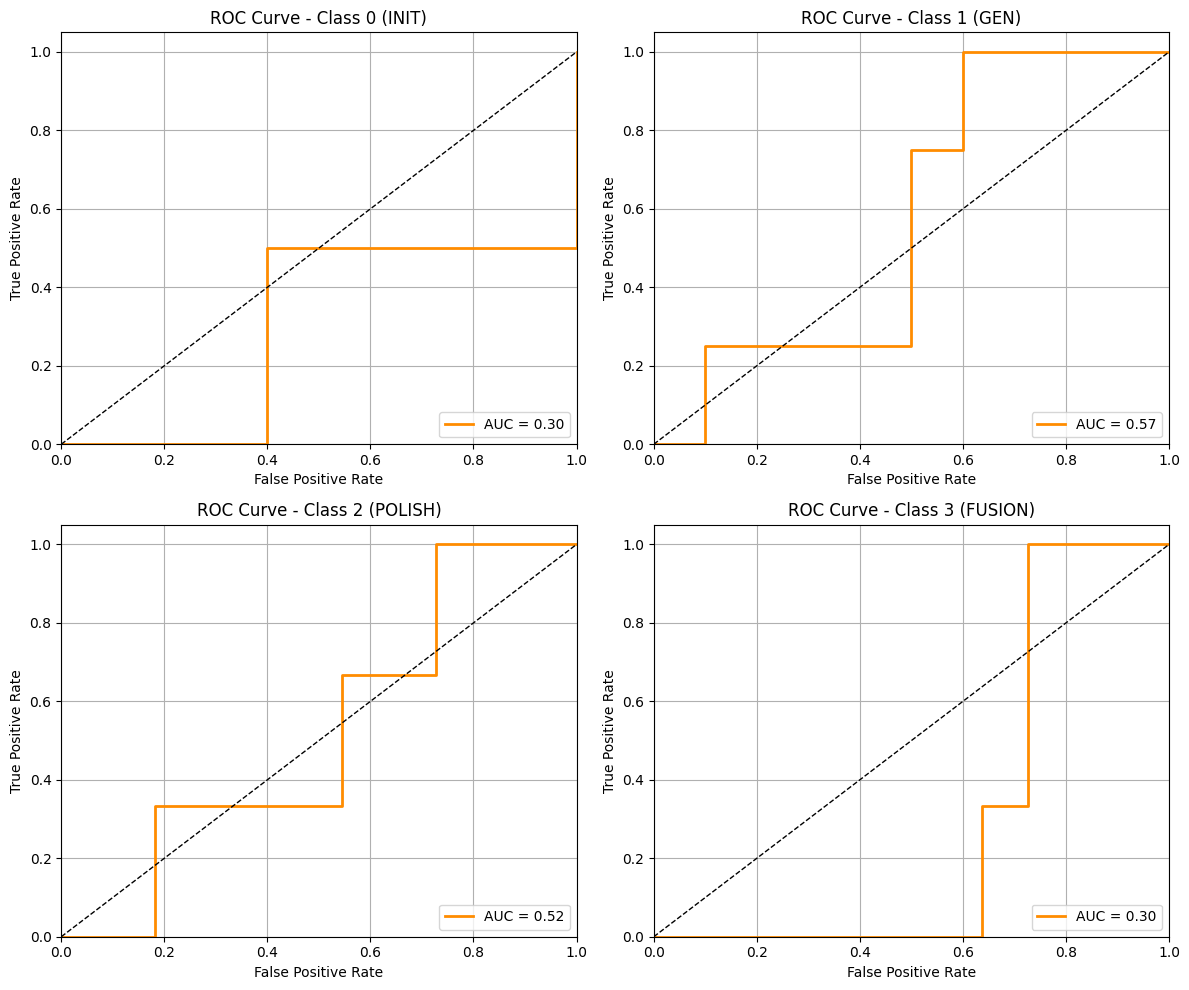

In [35]:
from sklearn.preprocessing import label_binarize

# Gán lại nhãn gốc
labels_test_orig = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3]
class_names = ["INIT", "GEN", "POLISH", "FUSION"]

# Nhị phân hóa nhãn gốc (one-hot)
labels_bin = label_binarize(labels_test_orig, classes=[0, 1, 2, 3])

# Vẽ ROC cho từng lớp
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i in range(4):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], all_probs[:, i])
    auc = roc_auc_score(labels_bin[:, i], all_probs[:, i])
    
    axs[i].plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='darkorange', lw=2)
    axs[i].plot([0, 1], [0, 1], 'k--', lw=1)
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel('False Positive Rate')
    axs[i].set_ylabel('True Positive Rate')
    axs[i].set_title(f"ROC Curve - Class {i} ({class_names[i]})")
    axs[i].legend(loc="lower right")
    axs[i].grid(True)

plt.tight_layout()
plt.savefig("roc_auc_4_classes_smooth.png")
plt.show()



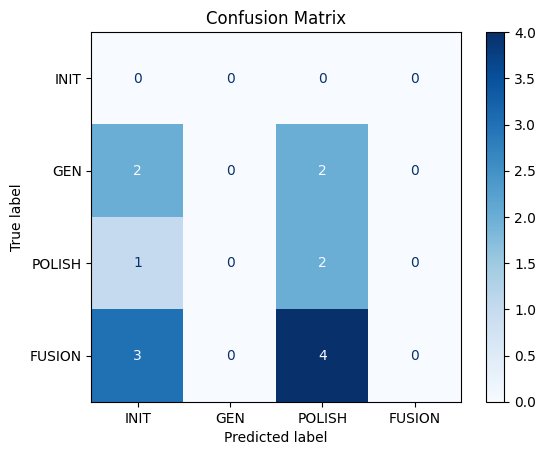

In [34]:

# ---------- VẼ Confusion Matrix ----------
cm = confusion_matrix(labels_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["INIT", "GEN", "POLISH", "FUSION"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()